In [192]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from scipy.stats import linregress

In [193]:
# Read data files
fitbit_1 = pd.read_csv("Resources/dailyCalories_merged_4.12.csv")
fitbit_2 = pd.read_csv("Resources/dailyIntensities_merged_4.12.csv")
fitbit_7 = pd.read_csv("Resources/sleepDay_merged_4.12.csv")

In [194]:
# Convert the ActivityDay & SleepDay data type to datatime format
fitbit_1["ActivityDay"] = pd.to_datetime(fitbit_1["ActivityDay"], format="%m/%d/%Y")
fitbit_2["ActivityDay"] = pd.to_datetime(fitbit_2["ActivityDay"], format="%m/%d/%Y")
fitbit_7['SleepDay'] = pd.to_datetime(fitbit_7['SleepDay'])

/var/folders/db/__hp954976g_m54sh0z8650w0000gn/T/ipykernel_43153/1495601747.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fitbit_7['SleepDay'] = pd.to_datetime(fitbit_7['SleepDay'])


In [195]:
# Merge data
fitbit_12 = pd.merge(fitbit_1, fitbit_2, how='left', on=['Id', 'ActivityDay'])

In [196]:
# Add new column 'AwakeTimeInBed'
AwakeTime = ['Id', 'SleepDay', 'TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed', 'AwakeTimeInBed']
fitbit_7_add = fitbit_7.reindex(columns=AwakeTime)

In [197]:
# Calculate 'AwakeTimeInBed' based on existing 2 columns 'TotalTimeInBed' & 'TotalMinutesAsleep'
fitbit_7_add['AwakeTimeInBed']=  fitbit_7_add['TotalTimeInBed'] - fitbit_7_add['TotalMinutesAsleep']

In [198]:
# Merge DataFrame
fitbit_127 = fitbit_12.merge(fitbit_7_add, how='left', left_on=['Id', 'ActivityDay'], right_on=['Id', 'SleepDay'])

In [199]:
# Drop missing values
fitbit_127_drop = fitbit_127.dropna()

The r-value is: 0.8657510739504785


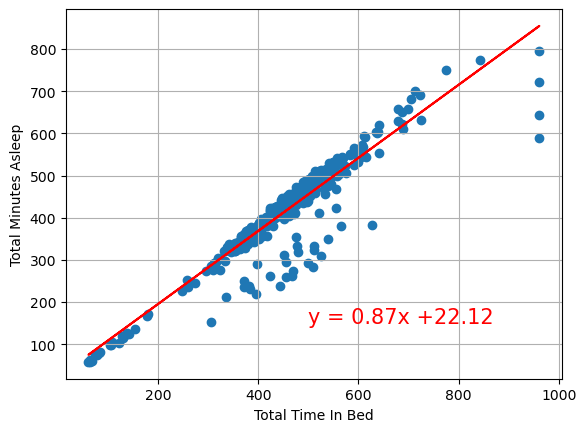

In [200]:
# Draw scatter plot between 'TotalTimeInBed' & 'TotalMinutesAsleep' + Run linear regression
x_value = fitbit_127_drop['TotalTimeInBed']
y_value = fitbit_127_drop['TotalMinutesAsleep']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_value, y_value)
regress_value = x_value * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_value,y_value)
plt.plot(x_value,regress_value,"r-")

plt.xlabel('Total Time In Bed')
plt.ylabel('Total Minutes Asleep')
plt.annotate(line_eq,(500,150),fontsize=15,color="red")
plt.grid()

print(f"The r-value is: {rvalue**2}")
plt.show()

In [201]:
# Filter the data 'TotalMinutesAsleep' witnin the range of 5-8.5 hours
fitbit_127_drop_filter = fitbit_127_drop.loc[(fitbit_127_drop['TotalMinutesAsleep'] >= 300) & (fitbit_127_drop['TotalMinutesAsleep'] <= 510)]

In [202]:
# Find rows which the 'AwakeTimeInBed' is either less than 10 minutes or more than 60 minutes
fitbit_127_drop_filter_awake_combined = fitbit_127_drop_filter.loc[(fitbit_127_drop_filter['AwakeTimeInBed'] >= 60) | (fitbit_127_drop_filter['AwakeTimeInBed'] <= 10)]

In [203]:
# Establish the bins
awaketime_bins = [0, 10, 60, 227]
labels = ["<10min", "10-60min", ">60min"]

In [204]:
# Make a copy of the original DataFrame
fitbit_127_drop_filter_awake_combined_copy = fitbit_127_drop_filter_awake_combined.copy()

In [205]:
# Categorize the AwakeTimeInBed based on the bins
fitbit_127_drop_filter_awake_combined_copy["Awake Time In Bed"] = pd.cut(fitbit_127_drop_filter_awake_combined_copy["AwakeTimeInBed"], bins = awaketime_bins, labels = labels)

In [206]:
# Calculate the median stats
df_cal = fitbit_127_drop_filter_awake_combined_copy.groupby(["Awake Time In Bed"])["Calories"].median()
df_very = fitbit_127_drop_filter_awake_combined_copy.groupby(["Awake Time In Bed"])["VeryActiveMinutes"].median()
df_fairly = fitbit_127_drop_filter_awake_combined_copy.groupby(["Awake Time In Bed"])["FairlyActiveMinutes"].median()
df_lightly = fitbit_127_drop_filter_awake_combined_copy.groupby(["Awake Time In Bed"])["LightlyActiveMinutes"].median()
df_seden = fitbit_127_drop_filter_awake_combined_copy.groupby(["Awake Time In Bed"])["SedentaryMinutes"].median()

/var/folders/db/__hp954976g_m54sh0z8650w0000gn/T/ipykernel_43153/704486750.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cal = fitbit_127_drop_filter_awake_combined_copy.groupby(["Awake Time In Bed"])["Calories"].median()
/var/folders/db/__hp954976g_m54sh0z8650w0000gn/T/ipykernel_43153/704486750.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_very = fitbit_127_drop_filter_awake_combined_copy.groupby(["Awake Time In Bed"])["VeryActiveMinutes"].median()
/var/folders/db/__hp954976g_m54sh0z8650w0000gn/T/ipykernel_43153/704486750.py:4: FutureWarning: The default of observed=False is deprecated and 

In [207]:
# Create a DataFrame that breaks down all stats based on the 'AwakeTimeInBed'
df_summary = pd.DataFrame({'Calories (median)': df_cal, 'VeryActiveMinutes (median)': df_very, 'FairlyActiveMinutes (median)': df_fairly, 'LightlyActiveMinutes (median)': df_lightly, 'SedentaryMinutes (median)': df_seden})

In [208]:
# Drop missing values (delete the row which the 'AwakeTimeInBed' is between 10-60 minutes)
df_summary_clean = df_summary.dropna()

In [209]:
# Display the data
df_summary_clean

,Calories (median),VeryActiveMinutes (median),FairlyActiveMinutes (median),LightlyActiveMinutes (median),SedentaryMinutes (median)
Awake Time In Bed,,,,,
<10min,2731.5,34.0,14.0,215.0,736.0
>60min,1624.0,11.0,22.0,191.5,676.0
